In [1111]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [1112]:
PATH_DATASET_TEST = './course_project_test.csv'
PATH_DATASET_TRAINT = './course_project_train.csv'
PATH_DATASET_TEST_RESULT = "./ESineokov_predictions.csv"

SCALER_FILE_PATH = './scaler.pkl'

df_train = pd.read_csv(PATH_DATASET_TRAINT)
df_test = pd.read_csv(PATH_DATASET_TEST)

df_test_result = df_test.copy()

In [1113]:
# methods
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 


def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def pretty_num(value):
    """
    Избавляемся от экспоненциальных данных
    """
    if type(value) == pd.core.series.Series:
        return value.apply(lambda x: format(x, '.1f') if type(x) != str else x)
    else:
        return format(value, '.1f')
    
def fill_nan_by_mean(dataframe, target, by, step):
    """
    Заполнить NaN поля подсчитав срееднее по другому полю
    dataframe: DataFrame
    target: поле в котором заполняем NaN
    by: поле по которму считаем среднее
    step: округление поля by с таким шагом.
    """
    def lam(data):
        if np.isnan(data[target]):
            return np.float64(mean_[round(data[by]/step)*step])
        return data[target]
    mean_ = df_train.groupby(df_train[by].apply(lambda x: round(x/step)*step))[target].mean()
    dataframe[target] = dataframe[[target, by]].apply(lam, axis=1)
    return dataframe

## Обзор обучающего датасета

### Описание полей:

* **Home Ownership** - Домовладение
* **Annual Income** - Годовой доход
* **Years in current job** - Количествл лет на текущей работе
* **Tax Liens** - Налоговые залоги
* **Number of Open Accounts** - Количество открытых счетов
* **Years of Credit History** - Количество лет кредитной истории
* **Maximum Open Credit** - Макисмальная сумма кредита
* **Number of Credit Problems** - Количество кредитных проблем
* **Months since last delinquent** - Количество месяцев с последне просрочки
* **Bankruptcies** - Банкротства
* **Purpose** - Цель
* **Term** - Срок
* **Current Loan Amount** - Текушая сумма кредита
* **Current Credit Balance** - Текущий кредитный баланс
* **Monthly Debt** - Ежемесячный долг
* **Credit Score** -  Кредитная оценка заёмщика (кредитный скоринг)
* **Credit Default** - Признак дефолта

### Обзор данных

In [1114]:
df_train.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [1115]:
df_test.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0


In [1116]:
df_train.info()

# Заполгнить пустые значения для: 
# Annual Income
# Years in current job
# Months since last delinquent
# Bankruptcies
# Credit Score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [1117]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Статистика

#### Числовые свойсва

In [1118]:
df_train.describe(
    percentiles=[.25, .50, .75, .95, .99]
).apply(pretty_num)

# Проверить на выбросы:
# Maximum Open Credit - проверить минимальные и максимальное значение
# Current Loan Amount - проверить значения 99999999 
# Current Credit Balance  - проверить минимальные значения
# Monthly Debt - проверить минимальные значения

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.0,7500.0,7500.0,7500.0,7500.0,7500.0,3419.0,7486.0,7500.0,7500.0,7500.0,5943.0,7500.0
mean,1366391.7,0.0,11.1,18.3,945153.7,0.2,34.7,0.1,11873177.4,289833.2,18314.5,1151.1,0.3
std,845339.2,0.3,4.9,7.0,16026216.7,0.5,21.7,0.3,31926123.0,317871.4,11926.8,1604.5,0.4
min,164597.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,11242.0,0.0,0.0,585.0,0.0
25%,844341.0,0.0,8.0,13.5,279229.5,0.0,16.0,0.0,180169.0,114256.5,10067.5,711.0,0.0
50%,1168386.0,0.0,10.0,17.0,478159.0,0.0,32.0,0.0,309573.0,209323.0,16076.5,731.0,0.0
75%,1640137.0,0.0,14.0,21.8,793501.5,0.0,50.0,0.0,519882.0,360406.2,23818.0,743.0,1.0
95%,2820297.3,0.0,20.0,31.9,1706333.2,1.0,75.0,1.0,99999999.0,766593.0,40546.2,6990.0,1.0
99%,4517246.6,1.0,27.0,40.4,3568459.4,2.0,80.0,1.0,99999999.0,1483079.4,58113.1,7390.0,1.0
max,10149344.0,7.0,43.0,57.7,1304726170.0,7.0,118.0,4.0,99999999.0,6506797.0,136679.0,7510.0,1.0


In [1119]:
df_test.describe(
    percentiles=[.25, .50, .75, .95, .99]
).apply(pretty_num)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1987.0,2500.0,2500.0,2500.0,2500.0,2500.0,1142.0,2497.0,2500.0,2500.0,2500.0,1987.0
mean,1366921.7,0.0,11.2,18.3,710570.4,0.2,34.2,0.1,12155719.6,296396.6,18271.3,1234.5
std,917125.2,0.4,4.9,7.3,1511983.5,0.6,22.0,0.4,32260973.7,378302.0,11543.9,1740.2
min,106533.0,0.0,1.0,3.9,0.0,0.0,0.0,0.0,15422.0,0.0,93.0,585.0
25%,852311.5,0.0,8.0,13.4,278586.0,0.0,16.0,0.0,187126.5,110114.5,10024.8,710.0
50%,1178475.0,0.0,10.0,17.0,478676.0,0.0,30.0,0.0,322366.0,207385.0,16642.5,731.0
75%,1629734.5,0.0,14.0,22.1,802598.5,0.0,50.0,0.0,522582.5,366348.5,24146.0,743.0
95%,2808732.0,0.0,20.0,31.8,1773928.2,1.0,75.0,1.0,99999999.0,748293.1,39148.5,7050.0
99%,4340327.3,1.0,27.0,41.5,4079982.7,2.0,80.0,1.0,99999999.0,1748232.6,55280.9,7400.0
max,14975610.0,15.0,48.0,53.4,54484386.0,15.0,82.0,5.0,99999999.0,6030087.0,93555.0,7480.0


#### Категориальные свойства

In [1120]:
df_train.describe(include = np.object)
# Будем преобразовывать категориальные данные через One Hot Encoding

,Home Ownership,Years in current job,Purpose,Term
count,7500,7129,7500,7500
unique,4,11,15,2
top,Home Mortgage,10+ years,debt consolidation,Short Term
freq,3637,2332,5944,5556


In [1121]:
df_test.describe(include = np.object)

,Home Ownership,Years in current job,Purpose,Term
count,2500,2414,2500,2500
unique,4,11,14,2
top,Home Mortgage,10+ years,debt consolidation,Short Term
freq,1225,810,1973,1861


## Обработка выбросов

### Maximum Open Credit

#### Нулевые значения

In [1122]:
# Количество полей с нулевыми значениями
df_train.loc[
    df_train['Maximum Open Credit'] == 0, 'Current Loan Amount'
].count()

65

In [1123]:
# Заполним нулевые значения текущим кредитом
df_train.loc[
    df_train['Maximum Open Credit'] == 0, 'Maximum Open Credit'
] = df_train.loc[
    df_train['Maximum Open Credit'] == 0, 'Current Loan Amount'
]

df_test.loc[
    df_test['Maximum Open Credit'] == 0, 'Maximum Open Credit'
] = df_test.loc[
    df_test['Maximum Open Credit'] == 0, 'Current Loan Amount'
]

# Убедимся, что не осталось "Maximum Open Credit" раных 0
df_test.loc[
    df_test['Maximum Open Credit'] == 0, 'Maximum Open Credit'
].count(), df_test.loc[
    df_test['Maximum Open Credit'] == 0, 'Maximum Open Credit'
].count()

(0, 0)

Text(0.5, 0, 'Maximum Open Credit')

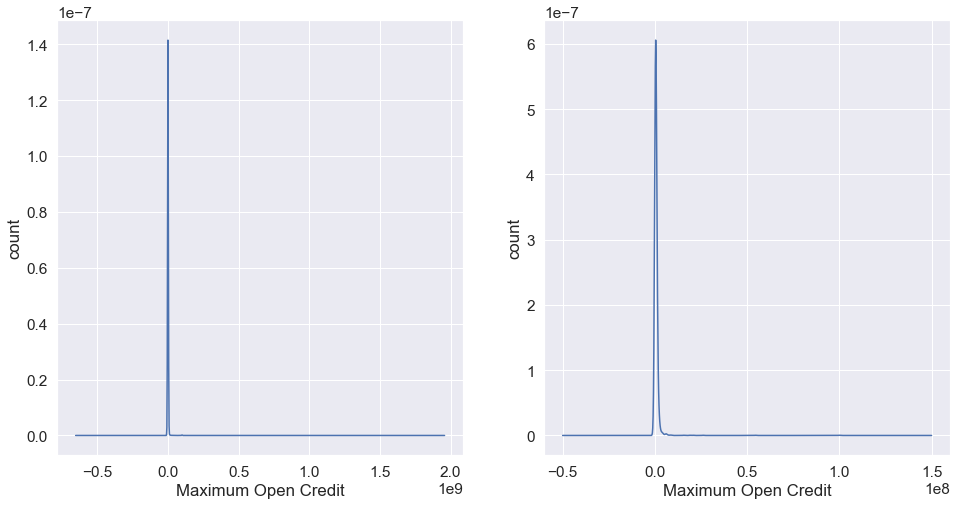

In [1124]:
# График
plt.figure(figsize = (16, 8))
plt.subplot(121)
df_train['Maximum Open Credit'].plot.kde()
plt.ylabel('count')
plt.xlabel('Maximum Open Credit')

plt.subplot(122)
df_test['Maximum Open Credit'].plot.kde()
plt.ylabel('count')
plt.xlabel('Maximum Open Credit')

# На графике и на статистике явно видно, что несколько значение сильно выбивается от остальных.
# Рассмотрим эти записи внимамательне

In [1125]:
# Выведем топ больших записей
df_train['Maximum Open Credit'].sort_values(ascending=True).tail(15).apply(pretty_num)

# Значения большие, но вполне могут быть реальными

7026      26406996.0
2763      40923894.0
2023      57562560.0
1464      99999999.0
4165      99999999.0
4962      99999999.0
2276      99999999.0
2297      99999999.0
3401      99999999.0
585       99999999.0
602       99999999.0
1984      99999999.0
2617     265512874.0
44       380052288.0
617     1304726170.0
Name: Maximum Open Credit, dtype: object

### Current Loan Amount

In [1126]:
# 99999999 в максимальных значения кажутся подозрительными
const_loan = 99999999
df_train.loc[df_train['Current Loan Amount'] == const_loan].shape,\
df_test.loc[df_train['Current Loan Amount'] == const_loan].shape


((870, 17), (284, 16))

Text(0.5, 0, 'Current Loan Amount')

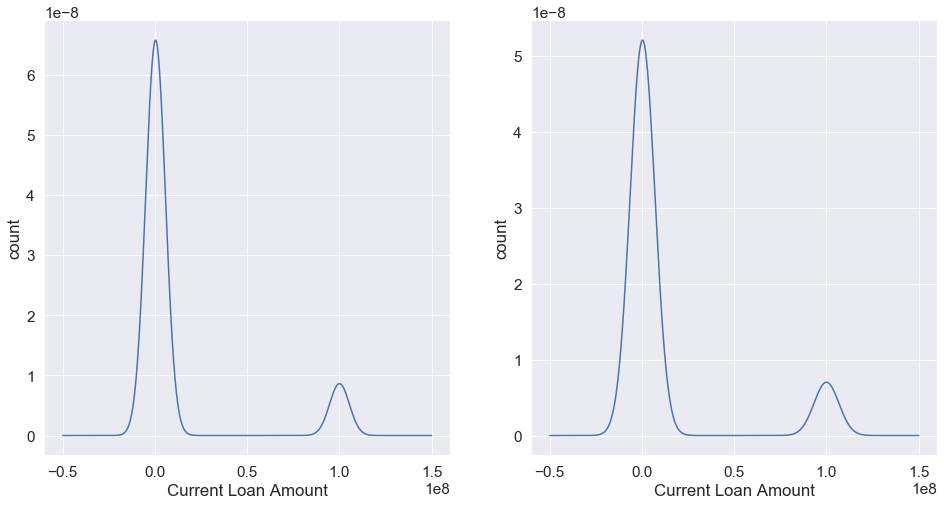

In [1127]:
# Построим графики
plt.figure(figsize = (16, 8))
plt.subplot(121)
df_train['Current Loan Amount'].plot.kde()
plt.ylabel('count')
plt.xlabel('Current Loan Amount')

plt.subplot(122)
df_test['Current Loan Amount'].plot.kde()
plt.ylabel('count')
plt.xlabel('Current Loan Amount')

In [1128]:
# Проверим есть ли связь с целевой переменной
df_train.loc[
    df_train['Current Loan Amount'] == const_loan
]['Credit Default'].sum()

# Все позиции, у которых Current Loan Amount == 99999999 относятся к нулевому классу
# Вывод: они могут помешать при постоение модели, но зато в тестовом датасете мо ним пожно сразу выставить нулевой класс

0

In [1129]:
# Удаляем записи с Current Loan Amount == 99999999 
df_train = df_train[~(df_train['Current Loan Amount'] == const_loan)]
df_train[df_train['Current Loan Amount'] == const_loan].size

0

### Current Credit Balance

In [1130]:
# Рассмотрим записи с Current Credit Balance == 0
df_train.loc[df_train['Current Credit Balance'] == 0].head(3)

# Данные выглядят правдободобно

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
91,Rent,601369.0,10+ years,0.0,6.0,16.9,165924.0,0.0,14.0,0.0,debt consolidation,Short Term,165924.0,0.0,9021.0,738.0,0
196,Rent,815157.0,7 years,0.0,3.0,8.8,218042.0,0.0,NaN,0.0,small business,Short Term,218042.0,0.0,5855.0,738.0,0
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,108042.0,0.0,NaN,0.0,home improvements,Short Term,108042.0,0.0,30340.0,742.0,0


### Monthly Debt

In [1131]:
df_train.loc[df_train['Monthly Debt'] == 0]
# Думаю, 5 записей с нелвыми значениями не сыграют отрицательной роли

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,75350.0,0.0,66.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1643,Rent,NaN,9 years,0.0,3.0,10.0,332156.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,NaN,10+ years,0.0,3.0,18.5,79200.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,210166.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0
7124,Rent,NaN,1 year,0.0,4.0,11.0,134024.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


## Обработка пропусков


### Annual Income  

In [1132]:
# Рассмотрим записи с отсуттсвующим годовым доходом
df_train.loc[df_train['Annual Income'].isnull()].head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,129734.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [1133]:
df_train = fill_nan_by_mean(df_train, 'Annual Income', 'Current Loan Amount', 5100)
df_train.head(3).apply(pretty_num)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,nan,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,nan,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,nan,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


In [1134]:
df_test = fill_nan_by_mean(df_test, 'Annual Income', 'Current Loan Amount', 5100)
df_test.head(3).apply(pretty_num)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,1056510.8,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,nan
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,nan,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0


In [1135]:
# Убадимся что пропусков в Annual Income не осталось
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'].count(), \
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'].count()

(0, 0)

### Years in current job 

In [1136]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'].shape, \
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'].shape

((330,), (86,))

In [1137]:
# Пустые значения заполним наиболее часто повторяющимися значениями
np.median(df_train['Years in current job'].value_counts().values),\
np.median(df_test['Years in current job'].value_counts().values)

(438.0, 153.0)

In [1138]:
df_train['Years in current job'].value_counts(),\
df_test['Years in current job'].value_counts()

(10+ years    2068
 2 years       617
 3 years       551
 < 1 year      503
 5 years       467
 1 year        438
 4 years       418
 6 years       366
 7 years       351
 8 years       291
 9 years       230
 Name: Years in current job, dtype: int64,
 10+ years    810
 3 years      228
 2 years      212
 < 1 year     207
 5 years      169
 1 year       153
 4 years      152
 7 years      140
 6 years      137
 8 years      107
 9 years       99
 Name: Years in current job, dtype: int64)

In [1139]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = '1 year'
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = '1 year'

df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,6.630000e+03,6630.000000,6630.000000,6630.000000,6.630000e+03,6630.000000,3048.000000,6619.000000,6630.000000,6.630000e+03,6630.000000,5073.000000,6630.000000
mean,1.349644e+06,0.030920,11.130468,18.292323,9.614985e+05,0.171493,34.687992,0.117843,309024.390347,2.881239e+05,18364.505430,1223.263749,0.318703
std,7.557286e+05,0.273168,4.923003,7.044410,1.702839e+07,0.502822,21.752647,0.348568,182294.008621,3.120490e+05,11881.789299,1726.313043,0.466009
min,1.645970e+05,0.000000,2.000000,4.000000,4.334000e+03,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,9.091975e+05,0.000000,8.000000,13.500000,2.785585e+05,0.000000,16.000000,0.000000,172744.000000,1.141852e+05,10151.750000,709.000000,0.000000
50%,1.210490e+06,0.000000,10.000000,17.000000,4.752880e+05,0.000000,32.000000,0.000000,265826.000000,2.091045e+05,16206.500000,730.000000,0.000000
75%,1.580696e+06,0.000000,14.000000,21.800000,7.848060e+05,0.000000,50.000000,0.000000,430100.000000,3.590192e+05,23881.500000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,1.000000


### Months since last delinquent

In [1140]:
# Отсутствующее значение "Количество месяцев с последней проблемы" заполним -9999
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = -9999
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = -9999

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6630 entries, 1 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                6630 non-null   object 
 1   Annual Income                 6630 non-null   float64
 2   Years in current job          6630 non-null   object 
 3   Tax Liens                     6630 non-null   float64
 4   Number of Open Accounts       6630 non-null   float64
 5   Years of Credit History       6630 non-null   float64
 6   Maximum Open Credit           6630 non-null   float64
 7   Number of Credit Problems     6630 non-null   float64
 8   Months since last delinquent  6630 non-null   float64
 9   Bankruptcies                  6619 non-null   float64
 10  Purpose                       6630 non-null   object 
 11  Term                          6630 non-null   object 
 12  Current Loan Amount           6630 non-null   float64
 13  Cur

### Bankruptcies

In [1141]:
df_train['Bankruptcies'].value_counts(), df_test['Bankruptcies'].value_counts()

(0.0    5885
 1.0     698
 2.0      28
 3.0       6
 4.0       2
 Name: Bankruptcies, dtype: int64,
 0.0    2252
 1.0     234
 2.0       5
 3.0       3
 5.0       2
 4.0       1
 Name: Bankruptcies, dtype: int64)

In [1142]:
# Пустые значения заменим 0
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6630 entries, 1 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                6630 non-null   object 
 1   Annual Income                 6630 non-null   float64
 2   Years in current job          6630 non-null   object 
 3   Tax Liens                     6630 non-null   float64
 4   Number of Open Accounts       6630 non-null   float64
 5   Years of Credit History       6630 non-null   float64
 6   Maximum Open Credit           6630 non-null   float64
 7   Number of Credit Problems     6630 non-null   float64
 8   Months since last delinquent  6630 non-null   float64
 9   Bankruptcies                  6630 non-null   float64
 10  Purpose                       6630 non-null   object 
 11  Term                          6630 non-null   object 
 12  Current Loan Amount           6630 non-null   float64
 13  Cur

### Credit Score

In [1143]:
df_train.loc[df_train['Credit Score'].isnull()].head(3).apply(pretty_num)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,Rent,1372101.0,7 years,0.0,12.0,14.6,366784.0,0.0,-9999.0,0.0,other,Long Term,337304.0,165680.0,18692.0,nan,1.0
8,Home Mortgage,1048969.5,5 years,0.0,17.0,15.7,129734.0,1.0,-9999.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,nan,0.0
9,Home Mortgage,1627566.9,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,nan,1.0


In [1144]:
# Отсутствующие кредитные скоры заменим средней по уровню дохода
df_train = fill_nan_by_mean(df_train, 'Credit Score', 'Annual Income', 17000)
df_test = fill_nan_by_mean(df_test, 'Credit Score', 'Annual Income', 17000)
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,6.630000e+03,6630.000000,6630.000000,6630.000000,6.630000e+03,6630.000000,6630.000000,6630.000000,6630.000000,6.630000e+03,6630.000000,6630.000000,6630.000000
mean,1.349644e+06,0.030920,11.130468,18.292323,9.614985e+05,0.171493,-5386.227602,0.117647,309024.390347,2.881239e+05,18364.505430,1209.283545,0.318703
std,7.557286e+05,0.273168,4.923003,7.044410,1.702839e+07,0.502822,5000.943856,0.348311,182294.008621,3.120490e+05,11881.789299,1515.572614,0.466009
min,1.645970e+05,0.000000,2.000000,4.000000,4.334000e+03,0.000000,-9999.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,9.091975e+05,0.000000,8.000000,13.500000,2.785585e+05,0.000000,-9999.000000,0.000000,172744.000000,1.141852e+05,10151.750000,716.000000,0.000000
50%,1.210490e+06,0.000000,10.000000,17.000000,4.752880e+05,0.000000,-9999.000000,0.000000,265826.000000,2.091045e+05,16206.500000,738.000000,0.000000
75%,1.580696e+06,0.000000,14.000000,21.800000,7.848060e+05,0.000000,29.000000,0.000000,430100.000000,3.590192e+05,23881.500000,919.666667,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,136679.000000,7510.000000,1.000000


## Отбор признаков

In [1145]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = [
    'Annual Income', 'Tax Liens', 'Number of Open Accounts',
    'Years of Credit History', 'Maximum Open Credit',
    'Number of Credit Problems', 'Months since last delinquent',
    'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
    'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = [
    'Home Ownership', 'Years in current job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES



## One Hot Encoding

In [1146]:
cat_encoded_train = pd.get_dummies(df_train[CAT_FEATURE_NAMES])
cat_encoded_test = pd.get_dummies(df_test[CAT_FEATURE_NAMES])

df_train = pd.concat([df_train[NUM_FEATURE_NAMES], cat_encoded, df_train[TARGET_NAME]], axis=1)
df_test = pd.concat([df_test[NUM_FEATURE_NAMES], cat_encoded_test], axis=1)

df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Credit Default
count,6.630000e+03,6630.000000,6630.000000,6630.000000,6.630000e+03,6630.000000,6630.000000,6630.000000,6630.000000,6.630000e+03,...,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000,6630.000000
mean,1.349644e+06,0.030920,11.130468,18.292323,9.614985e+05,0.171493,-5386.227602,0.117647,309024.390347,2.881239e+05,...,0.001207,0.090347,0.000302,0.003469,0.005128,0.001056,0.001810,0.271493,0.728507,0.318703
std,7.557286e+05,0.273168,4.923003,7.044410,1.702839e+07,0.502822,5000.943856,0.348311,182294.008621,3.120490e+05,...,0.034718,0.286700,0.017367,0.058801,0.071433,0.032478,0.042508,0.444763,0.444763,0.466009
min,1.645970e+05,0.000000,2.000000,4.000000,4.334000e+03,0.000000,-9999.000000,0.000000,11242.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.091975e+05,0.000000,8.000000,13.500000,2.785585e+05,0.000000,-9999.000000,0.000000,172744.000000,1.141852e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.210490e+06,0.000000,10.000000,17.000000,4.752880e+05,0.000000,-9999.000000,0.000000,265826.000000,2.091045e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.580696e+06,0.000000,14.000000,21.800000,7.848060e+05,0.000000,29.000000,0.000000,430100.000000,3.590192e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1147]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.00000,2500.000000,2.500000e+03,2.500000e+03,...,2500.000000,2500.000000,2500.0000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.362269e+06,0.035200,11.184400,18.325920,7.521823e+05,0.162000,-5415.84280,0.106800,1.215572e+07,2.963966e+05,...,0.003600,0.010800,0.0004,0.09600,0.002000,0.005600,0.001200,0.000800,0.255600,0.744400
std,8.372161e+05,0.386291,4.852774,7.254659,2.495492e+06,0.559894,4998.85325,0.356994,3.226097e+07,3.783020e+05,...,0.059904,0.103381,0.0200,0.29465,0.044686,0.074638,0.034627,0.028279,0.436285,0.436285
min,1.065330e+05,0.000000,1.000000,3.900000,4.444000e+03,0.000000,-9999.00000,0.000000,1.542200e+04,0.000000e+00,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.161990e+05,0.000000,8.000000,13.400000,2.797850e+05,0.000000,-9999.00000,0.000000,1.871265e+05,1.101145e+05,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.214993e+06,0.000000,10.000000,17.000000,4.811510e+05,0.000000,-9999.00000,0.000000,3.223660e+05,2.073850e+05,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.601781e+06,0.000000,14.000000,22.100000,8.026755e+05,0.000000,27.00000,0.000000,5.225825e+05,3.663485e+05,...,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.497561e+07,15.000000,48.000000,53.400000,1.000000e+08,15.000000,82.00000,5.000000,1.000000e+08,6.030087e+06,...,1.000000,1.000000,1.0000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Балансировка классов

In [1148]:
df_train = balance_df_by_target(df_train, TARGET_NAME)
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Credit Default
count,8.743000e+03,8743.000000,8743.000000,8743.000000,8.743000e+03,8743.000000,8743.000000,8743.000000,8743.000000,8.743000e+03,...,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000,8743.000000
mean,1.329682e+06,0.033284,11.185291,18.242514,8.696372e+05,0.174997,-5372.911930,0.117694,313284.383392,2.861425e+05,...,0.001144,0.091044,0.000458,0.004232,0.005033,0.001029,0.001830,0.299211,0.700789,0.483358
std,7.331766e+05,0.281618,4.941500,7.093491,1.483170e+07,0.512736,5001.921654,0.349836,183347.851461,3.015587e+05,...,0.033802,0.287688,0.021386,0.064919,0.070766,0.032070,0.042742,0.457939,0.457939,0.499752
min,1.645970e+05,0.000000,2.000000,4.000000,4.334000e+03,0.000000,-9999.000000,0.000000,11242.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.965530e+05,0.000000,8.000000,13.400000,2.736800e+05,0.000000,-9999.000000,0.000000,174592.000000,1.140760e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.191015e+06,0.000000,10.000000,17.000000,4.683360e+05,0.000000,-9999.000000,0.000000,268180.000000,2.093040e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.561734e+06,0.000000,14.000000,21.800000,7.732120e+05,0.000000,29.000000,0.000000,433554.000000,3.574945e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,789030.000000,6.506797e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Нормализация данных

In [1149]:
scaler = StandardScaler()

df_full = df_test.copy()
df_full = df_full.append(df_train.drop(TARGET_NAME, axis=1), ignore_index=True)

scaler.fit(df_full[NUM_FEATURE_NAMES])

df_train[NUM_FEATURE_NAMES] = scaler.transform(df_train[NUM_FEATURE_NAMES])
df_test[NUM_FEATURE_NAMES] = scaler.transform(df_test[NUM_FEATURE_NAMES])

df_train.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Credit Default
6912,-0.640378,-0.109465,-0.647183,-0.667836,-0.055584,-0.328719,-0.923156,-0.328,-0.180119,-0.712271,...,0,0,0,0,0,0,0,0,1,1
3876,0.701604,-0.109465,-0.850374,-1.172810,-0.046274,-0.328719,-0.923156,-0.328,-0.141743,-0.452797,...,0,0,0,0,0,0,0,0,1,0
417,-0.531522,-0.109465,-0.037609,-0.892269,-0.050742,-0.328719,1.081113,-0.328,-0.170769,-0.753984,...,0,0,0,0,0,0,0,0,1,0
6646,-0.493070,-0.109465,-1.256756,-1.495432,-0.041392,-0.328719,-0.923156,-0.328,-0.172726,-0.149059,...,0,0,0,0,0,0,0,0,1,1
2460,0.045275,-0.109465,0.775155,0.047543,-0.007110,-0.328719,1.089312,-0.328,-0.164801,0.626811,...,0,0,0,0,0,0,0,0,1,1


**Сохранение модели для нормализации данных**

In [1150]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test

In [1151]:
X = df_train.drop(columns=[TARGET_NAME])
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=7)

## LightGBM

In [1152]:
model_lgbm = lgbm.LGBMClassifier(
    random_state=21, n_estimators=1200, learning_rate=0.25, class_weight={0 : 1, 1 : 2.5})
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3340
           1       1.00      1.00      1.00      3217

    accuracy                           1.00      6557
   macro avg       1.00      1.00      1.00      6557
weighted avg       1.00      1.00      1.00      6557

TEST

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1177
           1       0.78      0.87      0.82      1009

    accuracy                           0.83      2186
   macro avg       0.83      0.83      0.83      2186
weighted avg       0.83      0.83      0.83      2186

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               925  252
1               130  879


In [1153]:
# Дообучаем модель на все train части для финального предсказания
model_lgbm = lgbm.LGBMClassifier(
    random_state=21, n_estimators=1200, learning_rate=0.25, class_weight={0: 1, 1: 2.5})
model_lgbm.fit(df_train.drop(columns=[TARGET_NAME], axis=1), df_train[TARGET_NAME])

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 2.5},
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.25, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=1200,
               n_jobs=-1, num_leaves=31, objective=None, random_state=21,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [1154]:
# Получим поля, которые могут отсутствовать в тестовом датасете
for i in df_train.columns:
    if i not in df_test.columns:
        print(i)

Purpose_renewable energy
Credit Default


In [1155]:
# Добавим в df_test отсутствующие поля
df_test['Purpose_renewable energy'] = 0
df_test.head(3)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,Purpose_renewable energy
0,-0.370141,-0.109465,-0.443991,-0.808106,-0.047410,-0.328719,1.090311,-0.328,-0.174139,-0.569984,...,0,0,0,0,0,0,0,0,1,0
1,-1.458680,-0.109465,-1.053565,2.025357,-0.059977,-0.328719,1.077913,-0.328,-0.179404,-0.756950,...,0,0,0,0,0,0,0,0,1,0
2,-0.243386,-0.109465,-0.240800,-0.639782,-0.048656,-0.328719,-0.923156,-0.328,-0.171781,-0.443244,...,0,0,0,0,0,0,0,0,1,0


## Предсказания для тестовых данных

In [1156]:
test_pred = model_lgbm.predict(df_test)

In [1157]:
df_test_result[TARGET_NAME] = test_pred

# Поскольку на этапе исследования данных мы выявили, 
# что все кредиты с Current Loan Amount == 99999999 относятся к нулевому классу, то выставм их принудительно
df_test_result.loc[df_test_result['Current Loan Amount'] == 99999999, TARGET_NAME] = 0

df_test_result.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000,2500.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860,0.275200
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442,0.446704
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000,0.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000,0.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000,0.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000,1.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000,1.000000


In [1158]:
# Сохраняем полученный результат
df_test_result.to_csv(PATH_DATASET_TEST_RESULT)

In [1159]:
df_test_result.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN,1
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,1


In [1160]:
df_test_result[TARGET_NAME].value_counts()

0    1812
1     688
Name: Credit Default, dtype: int64